# مقدمة

أثناء قراءة رواية سيدة الزمالك للكاتب أشرف عشماوي، وجدتني أحياناً أتوقف
في منتصف بعض الفصول لأسأل من المتكلم، لأن الرواية، على الرغم أنها متعددة
الأصوات، وتُروى على لسان سبعة شخصيات، لكنني لم أستطع التفريق من حيث
الشكل بين رواية هذا ورواية تلك. أي إنني لم أتمكن من سماع أصوات مختلفة
عند اختلاف الراوية، وكأنه راوٍ واحد يلبس قناع كلٍّ منهم عند سرده.

تذكرت عند ذلك أن بعض الكتّاب كان له أسلوب مميز في الكتابة، ومنهم مثلاً
وليام فولكنر، واستخدامه الترقيم والإملاء لإيصال فكرة ما، كما ذكر ذلك
الأستاذ توفيق الأسدي في مقدمة ترجمته لكتاب
«[بينما أرقد مُحتَضرة](https://www.goodreads.com/book/show/61801149)».
وكنت رأيت كذلك [صفحة](https://www.c82.net/work/?id=347) ملصقات فنية لعلامات الترقيم من عمل الفنان Nicholas Rougeux.
و[تدوينة](https://medium.com/@neuroecology/punctuation-in-novels-8f316d542ec4) خرائط حرارية لعلامات الترقيم من عمل Adam J Calhoun.

فحاولت أن أطبّق بعض أساليب تحليل البيانات على نصوص الرواية، للتأكد من
فرضية تشابه أساليب القص بين فصول الشخصيات.

> [!WARNING]
> ينبغي التنبيه إلى أنني لست متخصصاً في تحليل البيانات ولا في اللسانيات،
وقد يكون في بعض الأساليب المتبعة أخطاء أصلية قد تفقدها دلالتها بأكملها.

# إعداد البيانات

لم أضع ملفات الرواية هنا، حفاظاً على حقوق النشر، استعمل نسختك، وأنشأ
المجلد `chapters` وبداخله فصول كل شخصية من الكتاب صيغة epub كما يأتي،
لاحظ أيضاً أن ترقيم الفصول يخطأ بفاصل فصل منذ الفصل التاسع عشر:

|الفصل|اسم الملف|
|-|-|
|الفصل الأول|`chapters/nadia/part0007.xhtml`|
|الفصل الثاني|`chapters/abbas/part0008.xhtml`|
|الفصل الثالث|`chapters/zeynep/part0009.xhtml`|
|الفصل الرابع|`chapters/abbas/part0010.xhtml`|
|الفصل الخامس|`chapters/zeynep/part0011.xhtml`|
|الفصل السادس|`chapters/zeynep/part0012.xhtml`|
|الفصل السابع|`chapters/abbas/part0013.xhtml`|
|الفصل الثامن|`chapters/zeynep/part0014.xhtml`|
|الفصل التاسع|`chapters/abbas/part0015.xhtml`|
|الفصل العاشر|`chapters/nadia/part0016.xhtml`|
|الفصل الحادي عشر|`chapters/abbas/part0017.xhtml`|
|الفصل الثاني عشر|`chapters/nadia/part0018.xhtml`|
|الفصل الثالث عشر|`chapters/abbas/part0019.xhtml`|
|الفصل الرابع عشر|`chapters/nadia/part0020.xhtml`|
|الفصل الخامس عشر|`chapters/tarik/part0021.xhtml`|
|الفصل السادس عشر|`chapters/murat/part0022.xhtml`|
|الفصل السابع عشر|`chapters/zeynep/part0023.xhtml`|
|الفصل الثامن عشر|`chapters/nadia/part0024.xhtml`|
|الفصل التاسع عشر|`chapters/nadia/part0025.xhtml`|
|الفصل العشرون|`chapters/abbas/part0026.xhtml`|
|الفصل الحادي والعشرون|`chapters/zeynep/part0027.xhtml`|
|الفصل الثاني والعشرون|`chapters/tarik/part0028.xhtml`|
|الفصل الثالث والعشرون|`chapters/murat/part0029.xhtml`|
|الفصل الرابع والعشرون|`chapters/tarik/part0030.xhtml`|
|الفصل الخامس والعشرون|`chapters/nadia/part0031.xhtml`|
|الفصل السادس والعشرون|`chapters/murat/part0032.xhtml`|
|الفصل السابع والعشرون|`chapters/nadia/part0033.xhtml`|
|الفصل الثامن والعشرون|`chapters/zeynep/part0034.xhtml`|
|الفصل التاسع والعشرون|`chapters/nadia/part0035.xhtml`|

In [2]:
import os
import re
from collections import Counter
from itertools import tee
from math import ceil
from statistics import mean

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
from PIL import Image, ImageDraw
from wordcloud import WordCloud

plt.rcParams["font.family"] = (
    "Noto Sans Arabic, Noto Naskh Arabic, Amiri, DeJaVu Sans, sans-serif"
)
plt.rcParams["font.size"] = 10


def tr(text: str, render=True):
    terms = {
        "abbas": "عباس",
        "murat": "مراد",
        "nadia": "ناديا",
        "tarik": "طارق",
        "zeynep": "زينب",
        "character": "الشخصية",
        "chapters": "الفصول",
        "chapter count": "عدد الفصول",
        "sentences": "الجمل",
        "sentence count": "عدد الجمل",
        "sentence per chapter": "عدد الجمل في الفصل",
        "sentence length": "طول الجملة",
        "sentence lengths": "طول الجمل",
        "word": "الكلمة",
        "words": "الكلمات",
        "words per sentence": "الكلمات في الجملة",
        "word length": "طول الكلمة",
        "word lengths": "أطوال الكلمات",
        "frequency": "تكرار",
        "words frequency": "تكرار كلمات",
        "bigram": "الثنائية",
        "bigrams frequency": "تكرار ثنائيات",
        "total": "الإجمالي",
        "words frequency wordcloud": "سحابة لأكثر الكلمات ترداداً",
        "words frequency heatmap": "خريطة حرارية لتكرار الكلمات",
        "total repetition": "التكرار الإجمالي",
        "total word repetitions per character": "التكرار الإجمالي لكل شخصية",
        "repetition rate": "معدل التكرار",
        "tendency to repetition": "الميل إلى التكرار",
    }
    text = terms.get(text.lower()) or text
    if render:
        text = get_display(reshape(text))
    return text


def clean_text(text: str) -> str:
    text = text.replace("ـ", "")

    punctuations = {"?": "؟", ",": "،", ";": "؛"}
    for k, v in punctuations.items():
        text = text.replace(k, v)

    text = re.sub(r"^\s*|\s*$", "", text, flags=re.M)
    text = re.sub(r"[*]+", "", text)

    # Normalize letters
    text = text.replace("پ", "ب")
    text = text.replace("چ", "ج")

    text = re.sub(r"[ًٌٍَُِّْ]+", "", text)  # Remove diacritics
    return text.strip()


def html_to_text(html_file: str):
    with open(html_file, "r", encoding="utf8") as fp:
        html = fp.read()
        soup = BeautifulSoup(html, "html.parser")
        body = soup.find("body")
        if body is None:
            print(html_file, body)
        text = body.get_text(separator=" ").strip()
    return clean_text(text)


def strip_punctuations(text: str) -> str:
    punctuations = re.sub(r"\s+", "", text)  # Remove spaces
    punctuations = re.sub(r"\w", "", punctuations)  # Remove letters
    punctuations = re.sub(r"[*]+", "", punctuations)  # Remove other symbols
    return punctuations


def strip_sentences(text: str) -> list:
    sentences = re.split(r"[.!؟]+", text.strip())
    return [s.strip() for s in sentences if s]


def strip_words(text: str) -> list:
    # Match patterns like "عبد النعيم", "عبد الله", etc.
    abdul_pattern = r"عبد(?:\s+\w+)\b"

    # Match regular words (excluding digits)
    word_pattern = r"\b\w+\b"

    matches = re.findall(f"{abdul_pattern}|{word_pattern}", text)
    return [w.strip() for w in matches if not w.strip().isdigit()]


def words_per_sentence(sentences: list) -> list:
    return [len(strip_words(s)) for s in sentences]


def word_lengths(words: list) -> list:
    return [len(word) for word in words]


def word_filter(word: str) -> bool:
    ignored_words = [
        "أبدا",
        "أخرى",
        "أكثر",
        "أمام",
        "أنني",
        "أنها",
        "أيضا",
        "الآن",
        "التي",
        "الذي",
        "بعدما",
        "بعدها",
        "عليه",
        "عليها",
        "فجأة",
        "فيها",
        "قائلا",
        "قليلا",
        "كانت",
        "كلها",
        "لكنني",
        "لكنه",
        "لكنها",
        "ليلة",
        "منها",
        "هناك",
    ]

    if len(word) < 4:
        return False
    if word.isdigit():
        return False
    if word.startswith("و"):
        return False
    if word in ignored_words:
        return False

    return True


def words_counter(words: list) -> Counter:
    return Counter([w for w in words if word_filter(w)])


def most_used_words(words: list, top_n: int = 10) -> list:
    return words_counter(words).most_common(top_n)


def least_used_words(words: list, bottom_n: int = 10) -> list:
    return words_counter(words).most_common()[-bottom_n:]


def punctuation_usage(punctuations: list, chapter_count: int) -> Counter:
    punctuation_counts = Counter(punctuations)
    for punctuation in punctuation_counts:
        punctuation_counts[punctuation] /= chapter_count
    return punctuation_counts


def meta_heatmap(
    text: str|list[str], colors: dict, width: int = 500, height: int = 0, block_size: int = 8
) -> Image:
    width = width
    block_size = block_size
    if not height:
        height = ceil((len(text) * block_size) / width)
    img = Image.new("RGBA", (width, height))
    draw = ImageDraw.Draw(img)

    x = 0
    y = 0
    for p in text:
        if p in colors:
            this_colour = colors[p]
        else:
            this_colour = colors["unknown"]
        draw.rectangle((x, y, x + block_size, y + block_size), fill=this_colour)
        x += block_size
        if x >= width:
            x = 0
            y += block_size
    return img

def word_df(data, word_type="most_used_words"):
    structured_data = []
    for character, punctuations in {x: data[x][word_type] for x in data}.items():
        for word, frequency in punctuations:
            structured_data.append(
                {"Character": tr(character, False), "Word": word, "Frequency": frequency}
            )

    w_df = pd.DataFrame(structured_data)
    w_df["Word_Display"] = w_df["Word"].apply(lambda w: tr(w))
    w_df["Character_Display"] = w_df["Character"].apply(lambda w: tr(w))

    return w_df

data = {}
for dirpath, _, filenames in os.walk("chapters"):
    if not len(filenames):
        continue

    character = os.path.basename(dirpath)

    data[character] = {
        "chapter_count": 0,
        "punctuation_map": "",
        "chapters": [],
        "sentences": [],
        "words": [],
    }

    for chapter in filenames:
        if not chapter.endswith(".xhtml"):
            continue
        data[character]["chapter_count"] += 1
        data[character]["chapters"].append(
            int(chapter.removeprefix("part").removesuffix(".xhtml"))
        )

        text = html_to_text(os.path.join(dirpath, chapter))
        data[character]["punctuation_map"] += strip_punctuations(text)
        data[character]["sentences"] += strip_sentences(text)
        data[character]["words"] += strip_words(text)

for character in data:

    def count_per_chapter(x):
        return (
            len(data[character][x])
            if isinstance(data[character][x], str)
            else data[character][x]
        ) / data[character]["chapter_count"]

    data[character]["words_per_sentence"] = words_per_sentence(
        data[character]["sentences"]
    )

    data[character]["word_lengths"] = word_lengths(data[character]["words"])
    data[character]["most_used_words"] = most_used_words(data[character]["words"])
    data[character]["least_used_words"] = least_used_words(data[character]["words"])
    data[character]["punctuation_usage"] = punctuation_usage(
        data[character]["punctuation_map"].strip(""),
        data[character]["chapter_count"],
    )

# الفصول

يظهر هنا أن ناديا هي القاصّة الرئيسة للرواية، وبينما يقصّ زينب وعباس سبعة فصول، تقصّ هي تسعة، لكن هل هذه فصول طويلة أم قصيرة؟ وما الفكرة الرئيسة لهذه الفصول؟

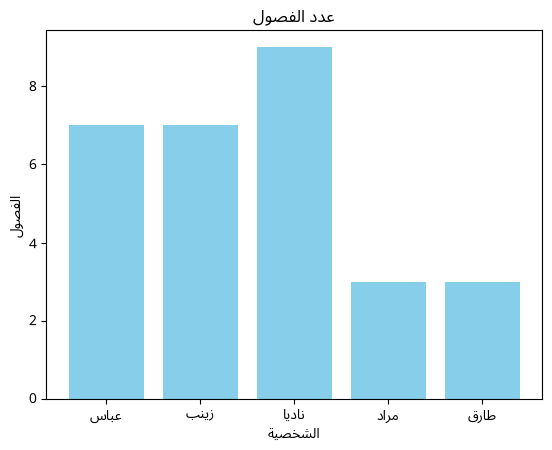

In [22]:
labels = list(map(tr, data.keys()))
values = [item["chapter_count"] for item in data.values()]

plt.bar(labels, values, color="skyblue")
plt.xlabel(tr("Character"))
plt.ylabel(tr("Chapters"))
plt.title(tr("Chapter Count"))
plt.show()

## الشخصيات الراوية للفصول

تسير الفصول حسب الألوان هنا إلى سير الرواية، وكل مربع يعطي فصل واللون يعطي الراوي

|الراوي|اللون|
|-|-|
|ناديا|🔴 أحمر|
|عباس|🟢 أخضر|
|زينب|🔵 أزرق|
|طارق|🟠 برتقالي|
|مراد|🟣 أرجواني|

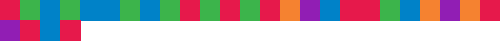

In [13]:
character_chapters = [
    c for _, c in sorted((ch, c) for c in data for ch in data[c]["chapters"])
]

colors = {
    "nadia": (230, 25, 75),  # Vivid Red
    "abbas": (60, 180, 75),  # Strong Green
    "zeynep": (0, 130, 200),  # Deep Blue
    "tarik": (245, 130, 48),  # Orange
    "murat": (145, 30, 180),  # Purple
}

img = meta_heatmap(character_chapters, colors, width=500, height=50, block_size=20)
display(img)

# الجمل

## عدد الجمل الإجمالي

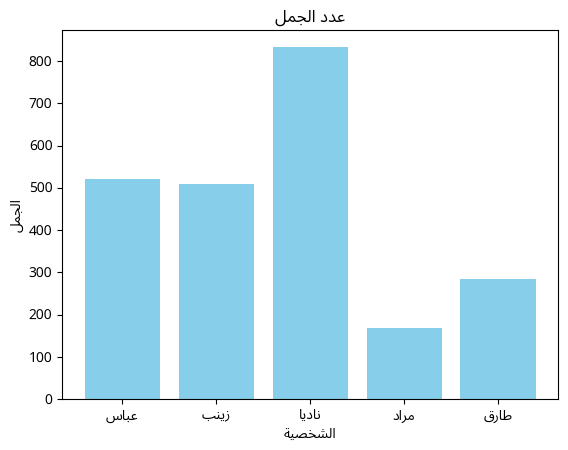

In [14]:
labels = list(map(tr, data.keys()))
values = [len(item["sentences"]) for item in data.values()]

plt.bar(labels, values, color="skyblue")
plt.xlabel(tr("Character"))
plt.ylabel(tr("Sentences"))
plt.title(tr("Sentence Count"))
plt.show()

## عدد الجمل في كل فصل

أيٌّ من هذه الشخصيات كانت ذات عدد جمل أطول في الفصل الواحد؟ $= \frac{\text{Sentence Lengths}}{\text{Chapter Count}}$

يظهر هنا أن فصول طارق وناديا ذات جمل أعلى من الباقي، وإن كان طارق يروي
ثلث عدد فصول ناديا. زينب وعباس يتشابهان مرة أخرى في طول جملهما في الفصل.

فصول مراد فيها جمل أقصر، وسنرى فيما بعد مزيداً عن هذه الجمل. وعلى الرغم
من أن طارق ومراد يروان ثلاثة فصول، فقد كان لطارق جمل قد تصل إلى ما دون
ضعفي جمل مراد بقليل.

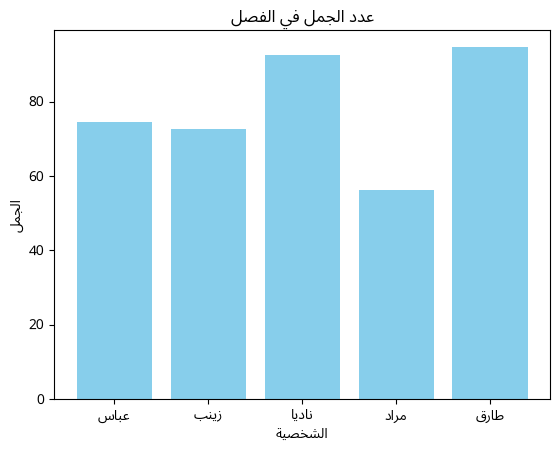

In [15]:
labels = list(map(tr, data.keys()))
values = [len(item["sentences"]) / item["chapter_count"] for item in data.values()]

plt.bar(labels, values, color="skyblue")
plt.xlabel(tr("Character"))
plt.ylabel(tr("Sentences"))
plt.title(tr("Sentence per Chapter"))
plt.show()

## متوسط عدد الكلمات في الجملة

أي المتوسط الحسابي لطول الجمل. عموماً تتقارب الشخصيات في طول الجملة، حيث
إن جمل جميع الرواة بين 35 والـ 40 كلمة في الجملة. من المنطقي إذن أن تكون
فصول مراد أقصر طالما أنه يتشابه معهم عموماً في متوسط طول الجمل، وعدد
جمله في الفصول أقصر.

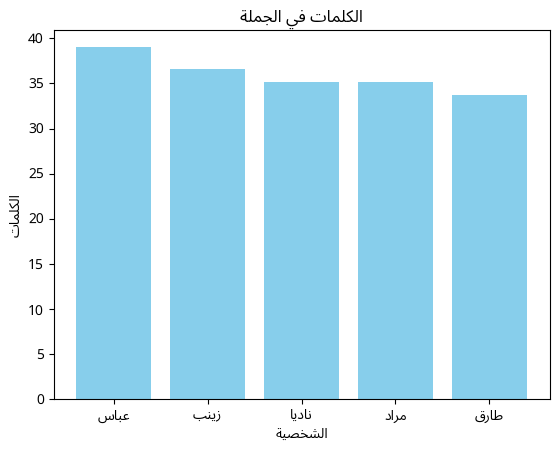

In [16]:
labels = list(map(tr, data.keys()))
values = [mean(item["words_per_sentence"]) for item in data.values()]

plt.bar(labels, values, color="skyblue")
plt.xlabel(tr("Character"))
plt.ylabel(tr("Words"))
plt.title(tr("Words per Sentence"))
plt.show()

# الكلمات

أذكر أنه من الصعوبة البالغة في العربية، أو اللغات التي تعتمد على ملحقات
كثيرة أن ننظر في أطوال الكلمات على أنها ذات دلالة. فنحتاج هنا أن نُرجع
كلمة «ولكنه» وهو خُماسية في نظر الحاسب، إلى ثلاث حروف «لكن» لنرى الطبيعة
اللغوية للشخصية، وهو ما لم أقُم به، ولا أنوي.

## أطوال الكلمات


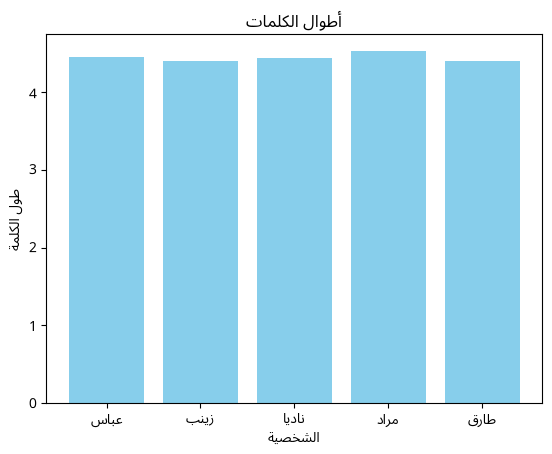

In [24]:
labels = list(map(tr, data.keys()))
values = [mean(item["word_lengths"]) for item in data.values()]

plt.bar(labels, values, color="skyblue")
plt.xlabel(tr("Character"))
plt.ylabel(tr("Word Length"))
plt.title(tr("Word Lengths"))
plt.show()

## أكثر الكلمات استعمالاً

وهنا أيضاً لم نقم بتجميع الكلمات على حسب جذورها، ولكنني قمت باستثناء ما يبدأ بالواو، فكثيراً ما تكون واو العطف (أو الأداة عموماً)، وتتبع العربية على عكس الفارسية طريقة إدماج الواو بالكلمة اللاحقة، وكذلك الحال في حرف الفاء وغيره من الأدوات. لكنني استثنيت الكلمات الشائعة كالأسماء الموصولة (انظر [إعداد البيانات](#إعداد-البيانات) في الأعلى)

In [28]:
word_df(data)[["Character", "Word", "Frequency"]]

,Character,Word,Frequency
0,عباس,حسانين,75
1,عباس,زينب,68
2,عباس,عبد النعيم,63
3,عباس,عباس,45
4,عباس,شيكوريل,45
5,عباس,زنانيري,42
6,عباس,فهيم,37
7,عباس,الخواجة,32
8,عباس,بولا,27
9,عباس,الفيلا,23


## أقل الكلمات استعمالاً


In [4]:
word_df(data, "least_used_words")[["Character", "Word", "Frequency"]]

,Character,Word,Frequency
0,عباس,أروح,1
1,عباس,ضروري,1
2,عباس,بالحذاء,1
3,عباس,السبب,1
4,عباس,فقالت,1
5,عباس,محتاجين,1
6,عباس,فراخ,1
7,عباس,نربيهم,1
8,عباس,السطوح,1
9,عباس,أخويا,1


## الكلمات التي تكررها الشخصيات

يظهر لي هنا أشياء:

تدور روايات **عباس** حول الوصول إلى حلمه عموماً، ويدل تكراره لكلمات مثل «عبد
النعيم» «حسانين» «شيكوريل» «زنانيري» على أن تفكيره ومخاوفه ماديّة
تماماً، وذلك برأيي أيضاً يشمل كلمة «زينب» إذا إنه ينظر لها نظرةً مختلفة
عن نظره إلى مجرد أخت. ولم تكن ناديا إحدى أكثر عشرة كلمات ذكرتها روايته.
على الرغم من محوريتها في الرواية.

ترتبط **زينب** بعباس تماماً، فأكثر كلمتين وردتا في روايتها هما «عباس»
و«پولا»، ويمكن اعتبارهما واحداً هنا، وقد كرُرت هاتين في فصول رواية زينب
أكثر تقريباً من مجموع الثمانية الباقية من الكلمات الأكثر تكراراً. مع إن
فيهم ابنتها، وناديا، ونساء النادي اللواتي رغبت في التفوق عليهن في
اجتماعياً. إن زينب لم يهدأ لها قرار، ولم يبرح خوفها أو تعلّقها بعباس في
روحها، حتى عندما لبست وجه المرأة المتسلطة.

**ناديا** عاشت على الخوف: من عمّتها أولاً، حيث نجمع «عمتي» و«زينب»، وإذا
أضفنا «مراد»، سنرى أن الجانب الذي تثيره هؤلاء الشخصيات لا يُقارن مع
الدعم التي حاولت تقديمه «مايسة» التي لا يمكن مقارنة ذكها بمجموع الثلاث
الأوَل.

**مراد**  &mdash; عباسٌ بالزي الميري، ولا أظن تكرار كلمة «ناديا» له أي
دِلالة عاطفية شعورية هنا.

**طارق** ليس الطفل الذي عرفته ناديا، وتغيّره يظهر من روايته بما يفوق ما
تتوقعه منه، بل يمكن تلخيص القول إن طارق الراوي، هو غير طارق الفكرة في
عقل ناديا. فبينما تلجأ ناديا إلى خلق فكرة طارق، الطفل عازف الكمان
والثورات الغاضبة؛ تجمّد هذه الفكرة وتنمو هي بينما تنبقيها ركيزة ترجع
إليها، ربما لافتقارها لما تحسّ بثباته في عالم شعوري يتصف بالفوضوية على
عكس الظاهر، ومسار الأحداث يدل على ذلك، حيث سعيها إلى إرساء شيء ثابت في
عالم باطني متغيّر، حيث تكشّف الأسرار شيئاً فشيئاً يلغي فكرة ناديا عن
الناس وعن ذاتها من جذورها.

بينما طارق الواقع، يتحدث عن «عادل رمزي»، الشخصية التي لم يكن لها تأثير حقيقي
على سير الأحداث سوى تغيير طارق، وعن «السجن» و«مراد».

ورود كلمة «الباب» هنا ورود لطيف غير مقصود، لكنه تعبير غير مقصود من الكاتب، ويذكر بجواب المخرج الإيراني الكبير عباس كيرُستمَي حين سُأل عن الأبواب في فلمه «أين منزل صديقي»، فأجاب بإن الأبواب ذات دلالة نفسية، وإن كان هو لم يكن يبحث عنها، لكن لعلها دخلت الفيلم عن لا وعيٍ منه، ككثير من رموز حياتنا، ويذكر بيت شعر فيه لعبة لغوية على كلمة الباب «دَر» من «گلستان / روضة الورد» لسعدي الشيرازي يقول:
<!--
فرق است میانِ آن که یارش در بر  ... تا آن که دو چشمِ انتظارش بر در
-->
ما ترجمته:

كم بين مَنْ كفه بالصدر عابثةٌ &mdash; وبين من عينُه للباب ترتقبُ

يُظهر **العد الإجمالي** للكلمات بأن محور الرواية، وبطلها، ومحركها الأساس
هو عباس، وزينب بالتبعية، وستظهر الكلمات المحورية في الصورة التالية في
سحابة الكلمات.

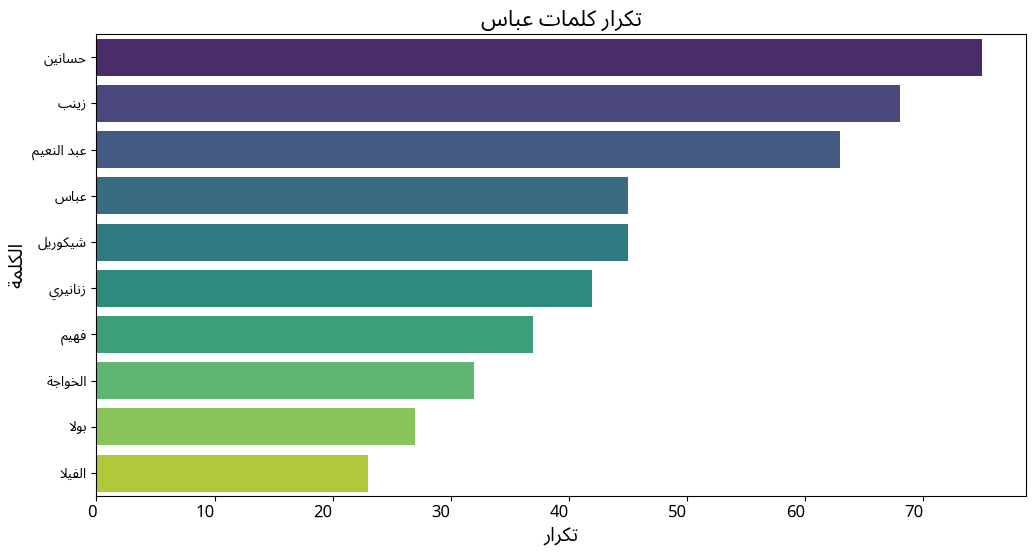

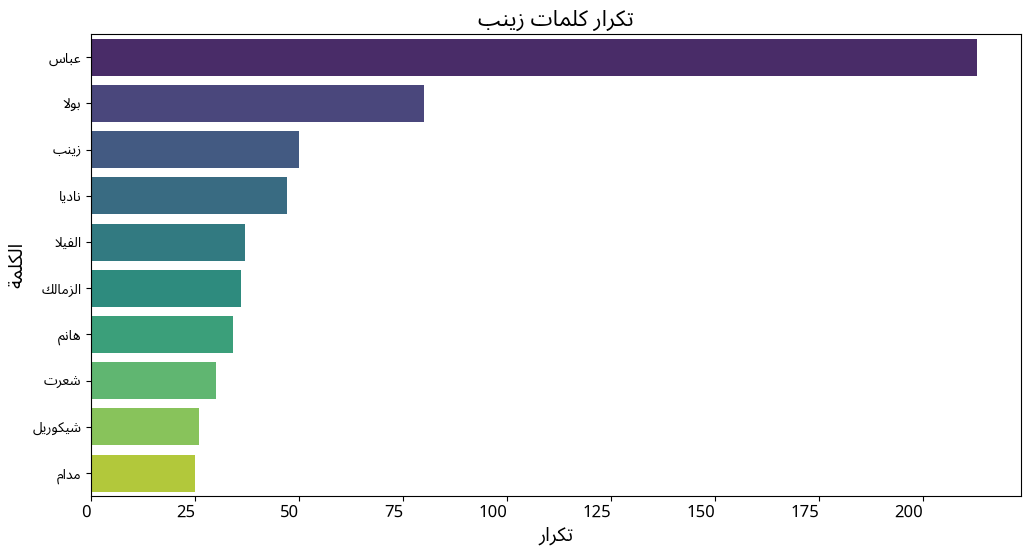

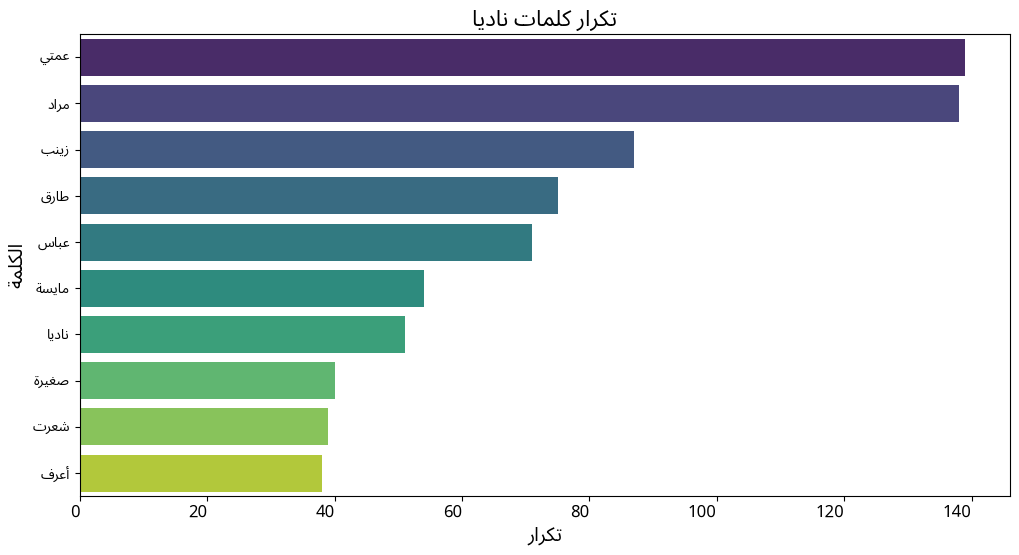

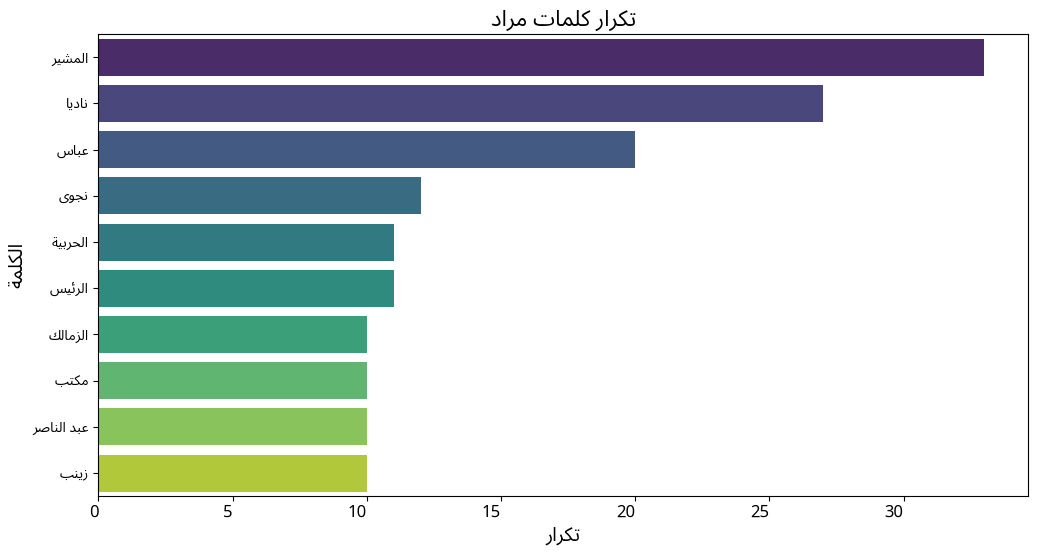

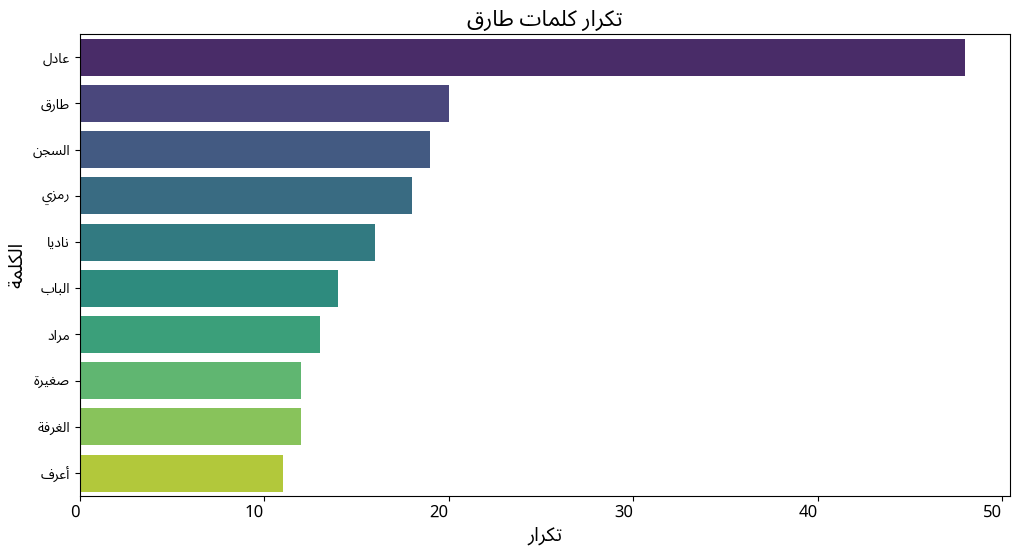

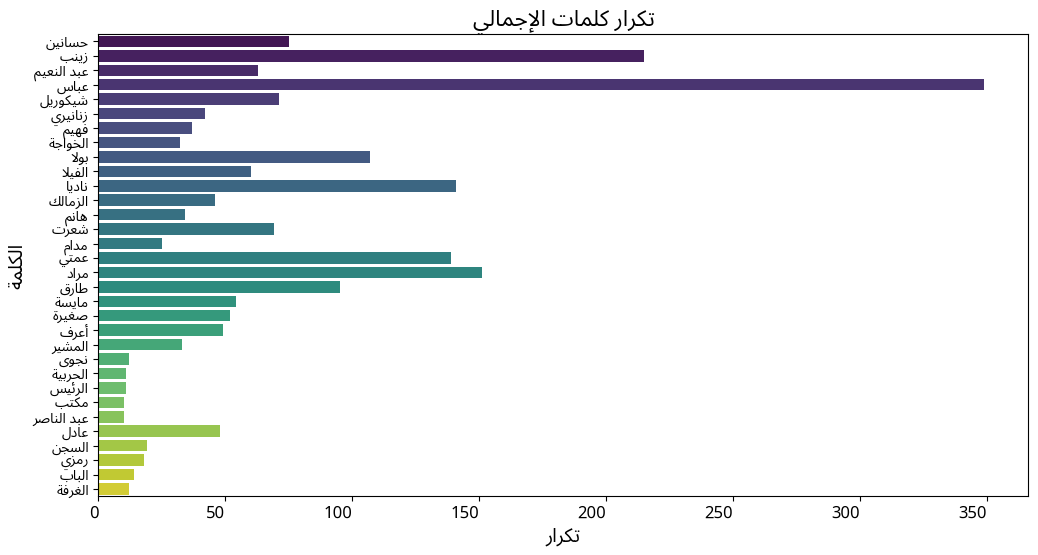

In [ ]:
def word_plot(plot_df, character, title: str = "Words Frequency", ylabel: str = "Word"):
    plot_df["Word_Display"] = plot_df["Word"].apply(lambda w: tr(w))

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=plot_df,
        y="Word_Display",
        x="Frequency",
        estimator=sum,
        errorbar=None,
        hue="Word_Display",
        palette="viridis",
        legend=False,
    )

    plt.xticks(rotation=0, ha="right", fontsize=12)
    plt.xlabel(tr("Frequency"), fontsize=14)
    plt.ylabel(tr(ylabel), fontsize=14)

    # Reverse order because it will be reshaped
    plt.title(f"{tr(character)} {tr(title)}", fontsize=16)

    plt.show()


total_data = []
for character, punctuations in {x: data[x]["most_used_words"] for x in data}.items():
    structured_data = []
    for word, frequency in punctuations:
        structured_data.append(
            {"Person": character, "Word": word, "Frequency": frequency}
        )
        total_data.append({"Person": character, "Word": word, "Frequency": frequency})
        character_df = pd.DataFrame(structured_data)
    word_plot(character_df, character)

word_plot(pd.DataFrame(total_data), "total")

## سحابة بأكثر الكلمات تكراراً

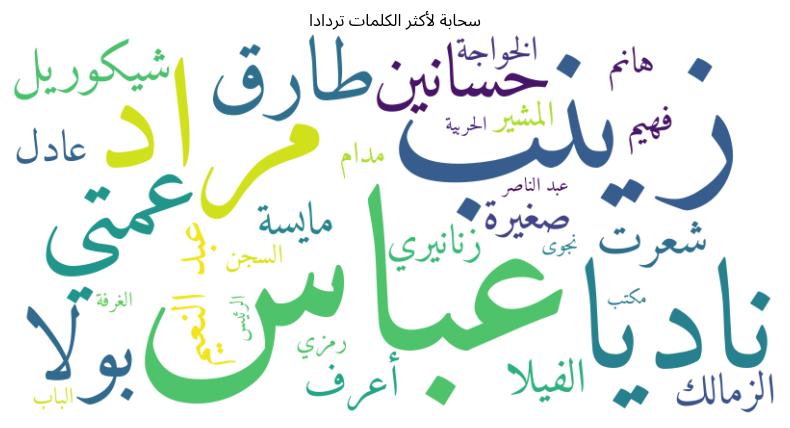

In [4]:
word_freqs = {}
for word, freq in word_df(data).groupby("Word")["Frequency"].sum().items():
    word_freqs[word] = freq

# If this did not work, edit font_path to the font you want to use
font_path = "arial" if os.name == "nt" else os.path.join(os.path.expanduser("~"), ".local/share/fonts/amiri-v27-arabic-regular.ttf")

wordcloud = WordCloud(
    font_path=font_path, width=800, height=400, background_color="white"
).generate_from_frequencies(word_freqs)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(tr("Words Frequency Wordcloud"))
plt.show()

## خريطة حرارية لمقارنة تكرار الكلمات بين الشخصيات

تكرر بعض الشخصيات كلمات لا تذكرها الشخصيات الأخرى في روايتها، أو لا تكاد، تظهر أهمية «عباس» هنا عند عدة شخصيات كذلك.

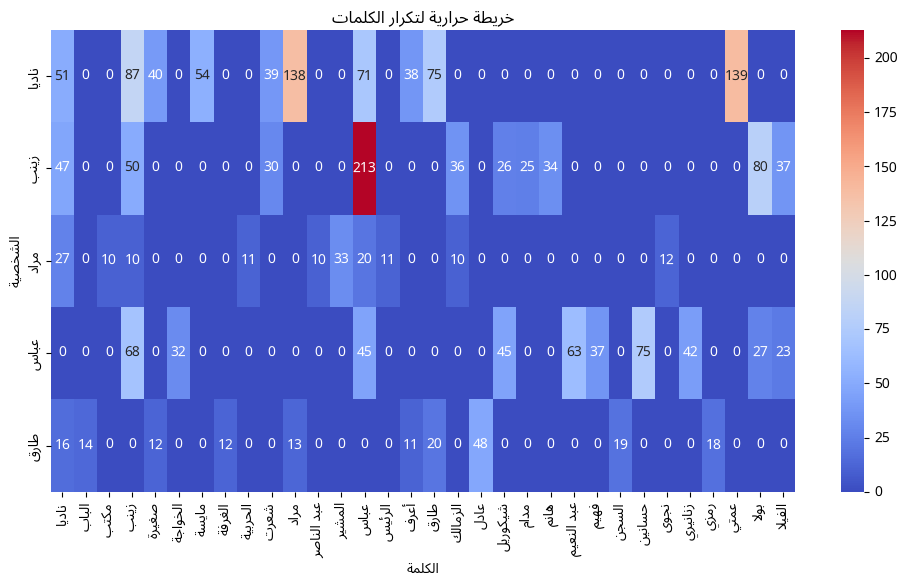

In [5]:
heatmap_data = word_df(data).pivot(
    index="Character_Display", columns="Word_Display", values="Frequency"
).fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".0f")

plt.title(tr("Words Frequency Heatmap"))
plt.xlabel(tr("Word"))
plt.ylabel(tr("Character"))

plt.show()

## التكرار الإجمالي لكل شخصية

هل تتكلم الشخصية عفواً؟ هل تكرر أو تعتمد على كلمات معينة؟  هل تحاول
اللجوء إلى كلمات جديدة لإظهار التفوق اللغوي؟

سنرى أولاً مجموع التكرارات وهو ما ليس له دِلالة كبيرة

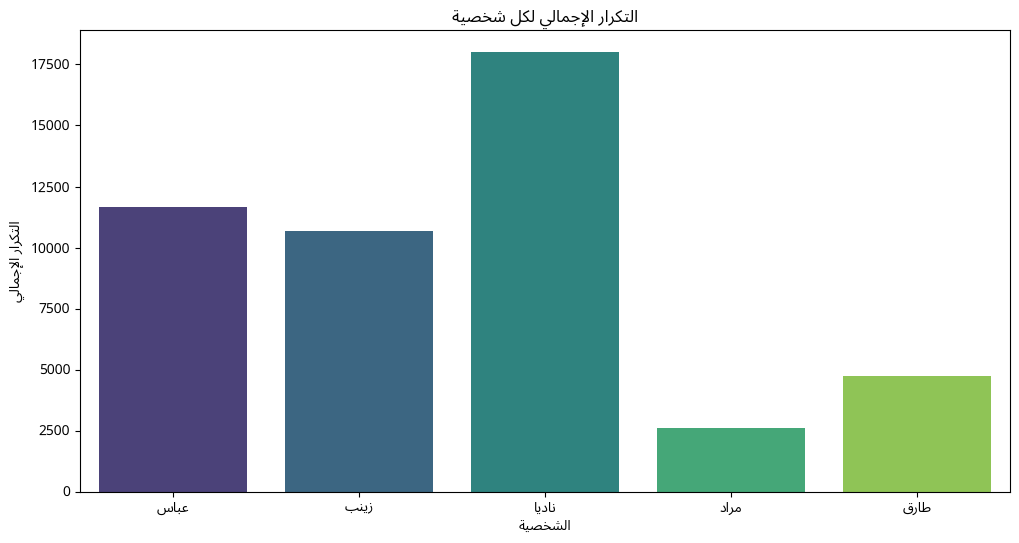

In [6]:

repeated_counts = {
    character: sum(count - 1 for count in Counter(info["words"]).values() if count > 1)
    for character, info in data.items()
}

repeated_words_df = pd.DataFrame.from_dict(
    repeated_counts, orient="index", columns=["Frequency"]
)
repeated_words_df.reset_index(inplace=True)
repeated_words_df.rename(columns={"index": "Character"}, inplace=True)

repeated_words_df["Character_Display"] = repeated_words_df["Character"].apply(
    lambda w: tr(w)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=repeated_words_df,
    x="Character_Display",
    y="Frequency",
    estimator=sum,
    errorbar=None,
    hue="Character_Display",
    palette="viridis",
)


plt.xlabel(tr("Character"))
plt.ylabel(tr("Total Repetition"))
plt.title(tr("Total Word Repetitions per Character"))

plt.show()

## الميل إلى التكرار

سأحاول النظر بسطحية إلى ميل الشخصية إلى التكرار، لا بعد التكرارات بغض
النظر عن الكلمة، ولكن بمعدل التكرار ويحسب بالعلاقة:

$\text{Repetition Rate} = \frac{\text{Total Repeated Words}}{\text{Total Word Count}}$

أي

$\text{Repetition Rate} = \frac{\sum_{w \in V} (\text{count}(w) - 1) \cdot \mathbf{1}_{\text{count}(w) > 1}}{\text{Total Words}}$

حيث:
- $V$: مجموعة الكلمات استعملتها إحدى الشخصيات
- $\text{count}(w)$ عدد مرات تكرار الكلمة $w$
- $\mathbf{1}_{\text{count}(w) > 1}$ معيار تكرار الكلمة، أن تُستعمل مرتين فصاعداً


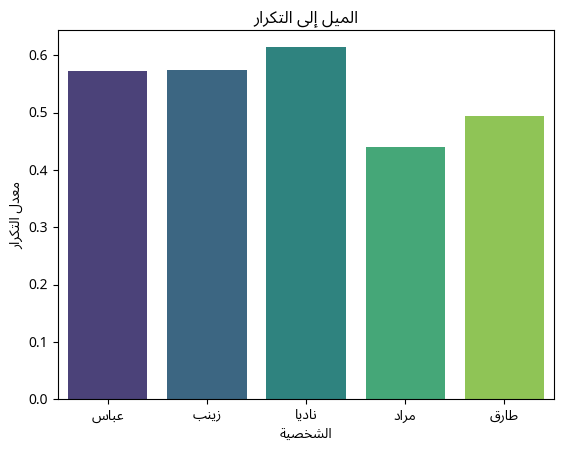

In [7]:
repetition_stats = []
for character, info in data.items():
    word_counts = Counter(info["words"])
    total_words = len(info["words"])
    total_repeated = sum(count - 1 for count in word_counts.values() if count > 1)

    repetition_rate = total_repeated / total_words if total_words > 0 else 0

    repetition_stats.append(
        {
            "Character": character,
            "Total Words": total_words,
            "Repeated Words": total_repeated,
            "Repetition Rate": repetition_rate,
        }
    )

repition_rate_df = pd.DataFrame(repetition_stats)
repition_rate_df["Character_Display"] = repition_rate_df["Character"].apply(
    lambda w: tr(w)
)


sns.barplot(
    data=repition_rate_df,
    x="Character_Display",
    y="Repetition Rate",
    estimator=sum,
    errorbar=None,
    hue="Character_Display",
    palette="viridis",
)

plt.xlabel(tr("Character"))
plt.ylabel(tr("Repetition Rate"))
plt.title(tr("Tendency to Repetition"))

plt.show()

لتحسين علاقة التكرار سنضيف وزن الكلمة، فالكلمات التي تكررت مائتي مرة ذات
دلالة أكبر في الميل إلى التكرار من تكرار كلمة عشر مرار مثلاً.

$\text{Repetition Rate} = \frac{\sum_{w \in V} \text{count}(w) \cdot \mathbf{1}_{\text{count}(w) > 1}}{\text{Total Words}}$

سنجد أن الميل إلى التكرار يعلو مع احتساب وزن لتكرار الكلمات، لكن المقارنة بين ميل الشخصيات إلى التكرار فيما بينهم لم تتغير، هل يدل ذلك على أن جميع الشخصيات تتحدث بلغة واحدة؟

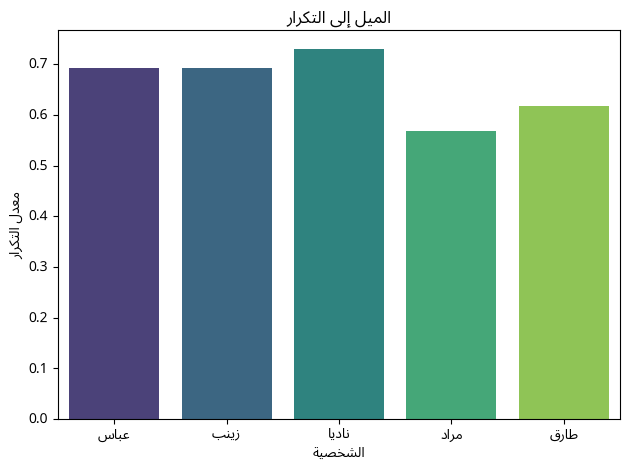

In [8]:
repetition_stats = []
for character, info in data.items():
    word_counts = Counter(info["words"])
    total_words = len(info["words"])
    total_repeated = sum(count - 1 for count in word_counts.values() if count > 1)
    total_weighted_repeated = sum(count for count in word_counts.values() if count > 1)

    repetition_rate = total_repeated / total_words if total_words > 0 else 0
    weighted_repetition_rate = total_weighted_repeated / total_words if total_words > 0 else 0

    repetition_stats.append(
        {
            "Character": character,
            "Total Words": total_words,
            "Repeated Words": total_repeated,
            "Repetition Rate": repetition_rate,
            "Weighted Repetition Rate": weighted_repetition_rate,
        }
    )

repition_rate_df = pd.DataFrame(repetition_stats)
repition_rate_df["Character_Display"] = repition_rate_df["Character"].apply(tr)

## Plot both for comparison
# fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# sns.barplot(
#     data=repition_rate_df,
#     x="Character_Display",
#     y="Repetition Rate",
#     hue="Character_Display",
#     palette="viridis",
#     ax=axes[0],
#     errorbar=None,
# )
# axes[0].set_title(tr("Simple Repetition Rate"))
# axes[0].set_xlabel(tr("Character"))
# axes[0].set_ylabel(tr("Rate"))

# sns.barplot(
#     data=repition_rate_df,
#     x="Character_Display",
#     y="Weighted Repetition Rate",
#     hue="Character_Display",
#     palette="plasma",
#     ax=axes[1],
#     errorbar=None,
# )
# axes[1].set_title(tr("Weighted Repetition Rate"))
# axes[1].set_xlabel(tr("Character"))

## Comment this if you want the double plots
sns.barplot(
    data=repition_rate_df,
    x="Character_Display",
    y="Weighted Repetition Rate",
    estimator=sum,
    errorbar=None,
    hue="Character_Display",
    palette="viridis",
)

plt.xlabel(tr("Character"))
plt.ylabel(tr("Repetition Rate"))
plt.title(tr("Tendency to Repetition"))

plt.tight_layout()
plt.show()

# الثنائيات والتركيبات

ربما لا يظهر تحليل واقعي عند النظر إلى الكلمات المفردة، ولكن إذا أردنا أن نستعلم عن نمط الكلام
فلعلنا ننظر في الثنائيات (كلمتين) والتركيبات (ثلاثة فأكثر).

في الغالب لم تظهر تكرارات لأكثر من كلمتين، لذلك سأعيد كتابة البرنامج للكلمات المفردة،
وسأكتب وظائف عامة لتوليد التركيبات ذات العدد س من الكلمات.

In [ ]:
def ngram_counts(lst, n=2):
    iters = tee(lst, n)
    for i, it in enumerate(iters):
        for _ in range(i):
            next(it, None)
    return Counter(list(zip(*iters)))


def bg_lists(words: list[str], most_common: int = 10):
    bg_list_sorted = sorted(
        ngram_counts(words, 2).most_common(most_common),
        key=lambda kv: kv[1],
        reverse=True,
    )

    bg, counts = zip(*bg_list_sorted)
    bg_str = [" ".join(pair) for pair in bg]
    return counts, bg_str


for character in data:
    counts, bg_str = bg_lists([w for w in data[character]["words"] if word_filter(w)])
    df = pd.DataFrame({"Word": bg_str, "Frequency": counts})
    word_plot(df, character, title="Bigrams Frequency", ylabel="Bigram")

all_words = [w for c in data for w in data[c]["words"] if word_filter(w)]
total_counts, total_bg_str = bg_lists(all_words)
word_plot(pd.DataFrame({"Word": total_bg_str, "Frequency": total_counts}), "total")

# علامات الترقيم

## متوسط استعمال علامات الترقيم في الفصل لكل شخصية

التقارب بين زينب وعباس يظهر قربهما الحقيقي، ونشأتهما الطبقية. مراد بخيل بعلامات الترقيم!

In [9]:
structured_data = {}
for c in data:
    structured_data[tr(c, False)] = data[c]["punctuation_usage"]
df = pd.DataFrame(structured_data)
df.fillna(value=0, inplace=True)
df

,عباس,زينب,ناديا,مراد,طارق
«,7.428571,7.142857,8.333333,5.000000,6.000000
»,7.428571,7.142857,8.333333,5.000000,6.000000
،,225.857143,220.714286,265.000000,131.666667,266.000000
.,55.142857,52.857143,76.333333,51.666667,73.333333
!,34.285714,33.714286,39.333333,19.666667,40.333333
؟,13.142857,13.285714,13.777778,7.666667,20.000000
:,14.428571,13.142857,12.111111,10.333333,17.000000
-,23.428571,20.857143,18.111111,17.000000,26.666667
(,0.285714,0.000000,0.222222,0.000000,0.000000
),0.285714,0.000000,0.222222,0.000000,0.000000


## خرائط حرارية لاستعمال علامات الترقيم

### خريطة حرارية تظهر استعمال علامات الترقيم

|العلامة|اللون|
|-|-|
|`.`|🔴 أحمر (نهاية جملة)|
|`؟`|🔴 أحمر (نهاية جملة)|
|`%`|🔴 أحمر (نهاية جملة)|
|`!`|🔴 أحمر (نهاية جملة)|
|`،`|🔵 أزرق (سكتة لطيفة)|
|`"`|🔵 أزرق (سكتة لطيفة)|
|`'`|🔵 أزرق (سكتة لطيفة)|
|`’`|🔵 أزرق (سكتة لطيفة)|
|`:`|🟢 أخضر (شرح، الوقف ممكن)|
|`؛`|🟢 أخضر (شرح، الوقف ممكن)|
|`»`|🟢 أخضر (شرح، الوقف ممكن)|
|`«`|🟢 أخضر (شرح، الوقف ممكن)|
|`)`|🟢 أخضر (شرح، الوقف ممكن)|
|`(`|🟢 أخضر (شرح، الوقف ممكن)|
|`-`|🟢 أخضر (شرح، الوقف ممكن)|
|`غير ذلك`|⚪ رمادي|

#### عباس

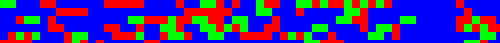

#### زينب

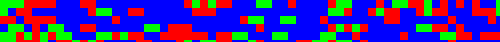

#### ناديا

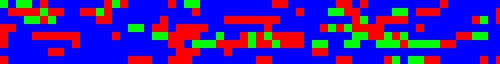

#### مراد

#### طارق

In [10]:
def punctuation_heatmap(punctuations: str) -> Image:
    colors = {
        ".": (255, 0, 0),
        "؟": (255, 0, 0),
        "%": (255, 0, 0),
        "!": (255, 0, 0),
        "،": (0, 0, 255),
        '"': (0, 0, 255),
        "'": (0, 0, 255),
        "’": (0, 0, 255),
        ":": (0, 255, 0),
        "؛": (0, 255, 0),
        "»": (0, 255, 0),
        "«": (0, 255, 0),
        ")": (0, 255, 0),
        "(": (0, 255, 0),
        "-": (0, 255, 0),
        "unknown": (128, 128, 128),
    }
    return meta_heatmap(punctuations, colors)


for character in data:
    img = punctuation_heatmap(data[character]["punctuation_map"])
    display(Markdown(f"#### {tr(character, False)}"))
    display(img)

### خريطة حرارية لسير حديث الراوي

الخريطة هنا تُظهر سير حديث الراوي، ويدل اللون الرمادي ⚪ على سير الحديث،
والبرتقالي 🟠 على سكتة لطيفة (فاصلة أو فاصلة منقوطة)، ويدل الأحمر 🔴 على نهاية
جملة (نقطة، إشارة استفهام أو تعجب أو نقطتين شارحتين).

#### عباس

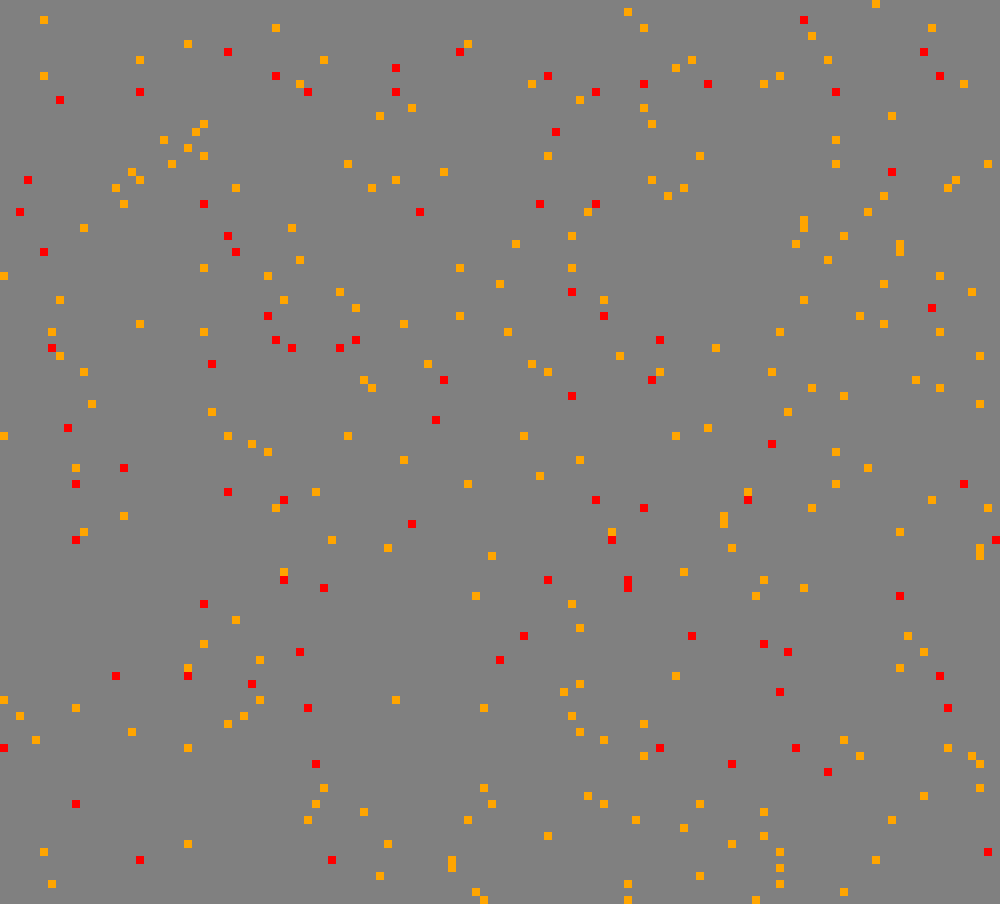

#### زينب

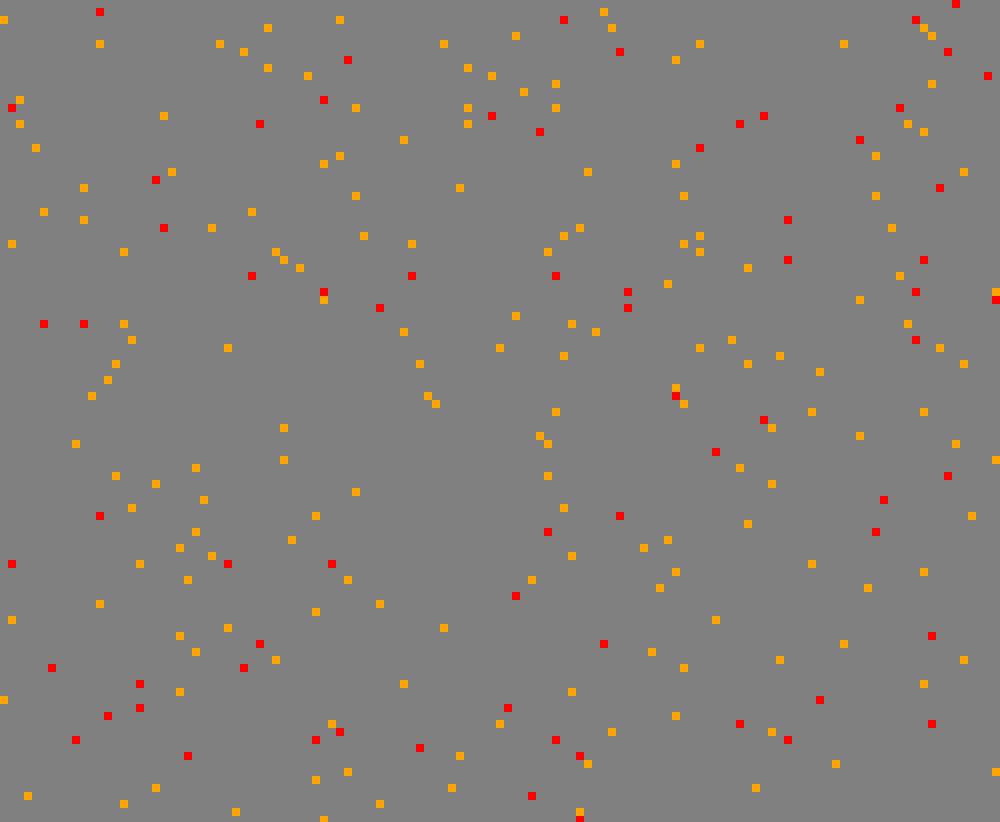

#### ناديا

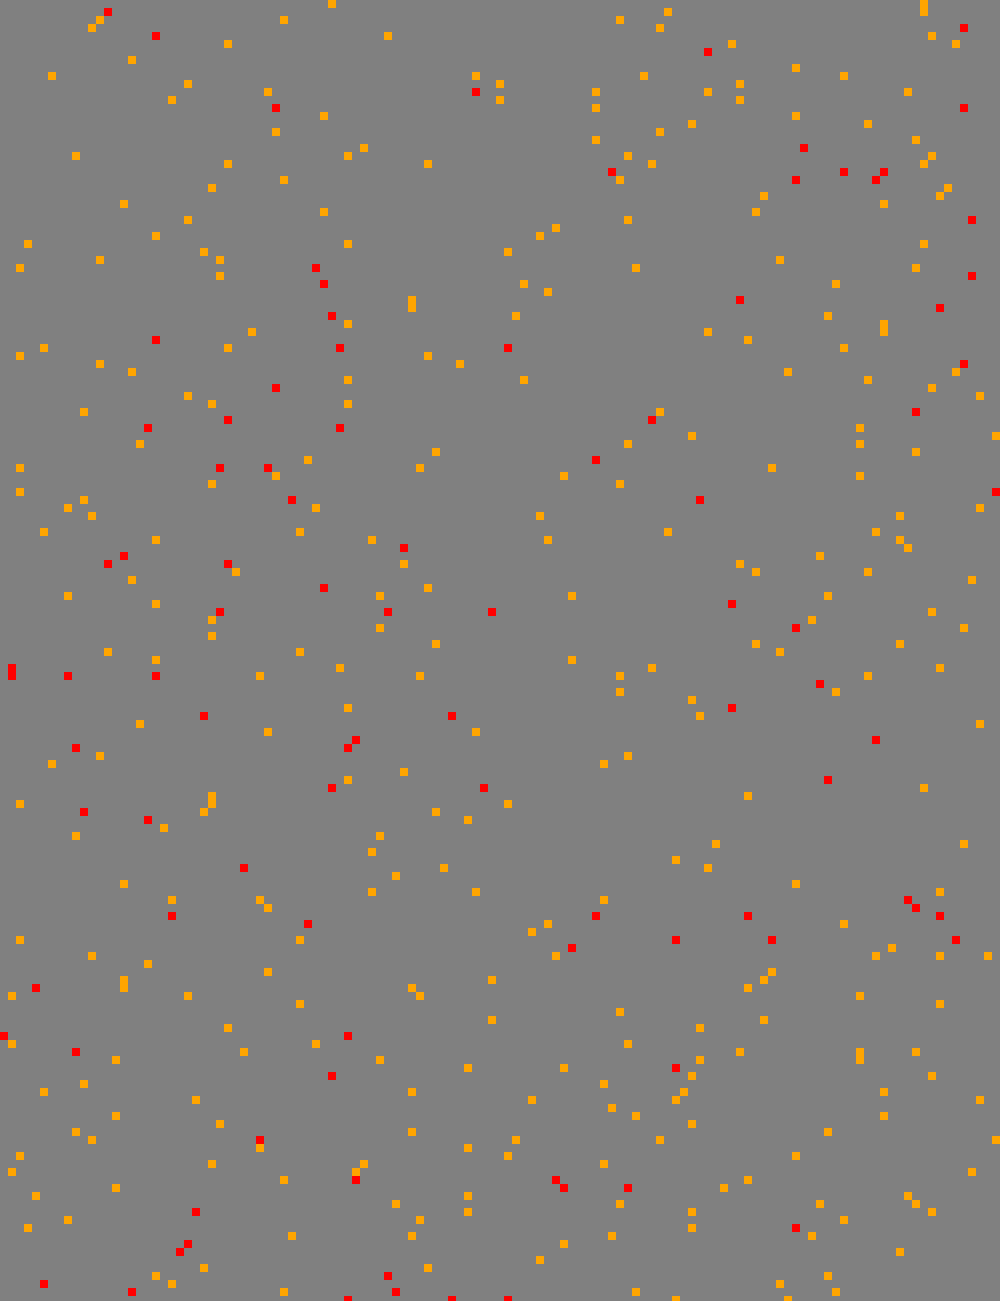

#### مراد

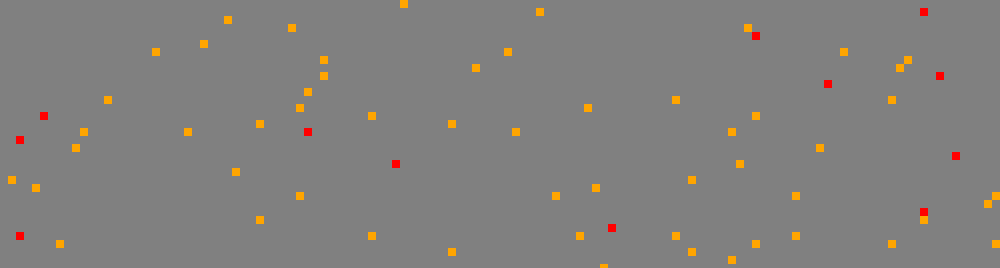

#### طارق

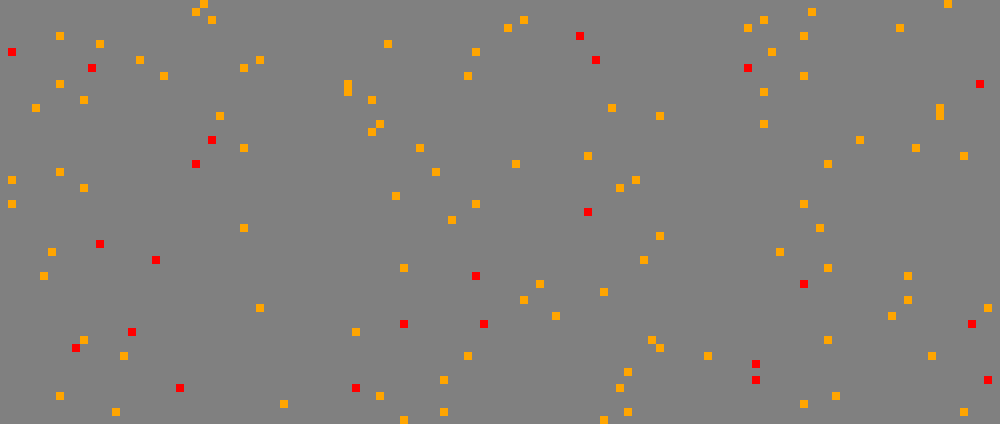

In [11]:
def pause_heatmap(sentences: list[str]) -> Image:
    short_pauses = ["،", "؛"]
    long_pauses = [".", ":", "؟", "!"]

    colors = {
        "unknown": (128, 128, 128),
    }

    for p in short_pauses:
        colors[p] = (255, 165, 0)
    for p in long_pauses:
        colors[p] = (255, 0, 0)

    text = ".".join(sentences)
    return meta_heatmap(text, colors, width=1000)


for character in data:
    img = pause_heatmap(data[character]["sentences"])
    display(Markdown(f"#### {tr(character, False)}"))
    display(img)

### بصمة سير الحديث

تظهر الخرائط هنا بصمة لكل شخصية كيف تتحديث وتقف، ومتى تقف مطوّلاً،
يدل الأخضر 🟢 على الحديث، واستمرار الحديث (الجملة) يُعطى بمربع واحد فقط.
الأحمر 🔴 للتوقف، والبرتقالي 🟠 للسكت اللطيف.

#### عباس

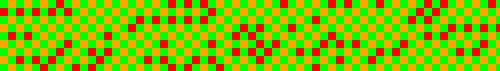

#### زينب

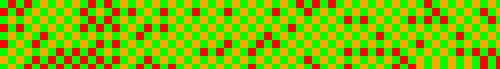

#### ناديا

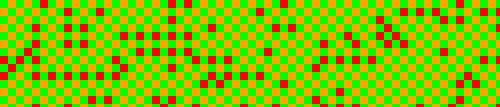

#### مراد

#### طارق

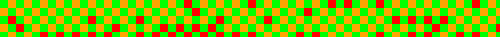

In [12]:
def pause_fingerprint_heatmap(sentences: list[str]) -> Image:
    short_pauses = ["،", "؛"]
    long_pauses = [".", ":", "؟", "!"]

    short_pauses_regex = r"[{}]+".format("".join(short_pauses))
    long_pauses_regex = r"[{}]+".format("".join(long_pauses))
    no_pauses_regex = r"[^{}]+".format("".join(short_pauses + long_pauses))

    colors = {
        "unknown": (0, 255, 0),
    }

    for p in short_pauses:
        colors[p] = (255, 165, 0)
    for p in long_pauses:
        colors[p] = (255, 0, 0)

    text = ".".join(sentences)
    text = re.sub(short_pauses_regex, "،", text)
    text = re.sub(long_pauses_regex, ".", text)
    text = re.sub(no_pauses_regex, "x", text)

    return meta_heatmap(text, colors)


for character in data:
    img = pause_fingerprint_heatmap(data[character]["sentences"])
    display(Markdown(f"#### {tr(character, False)}"))
    display(img)